In [1]:
%load_ext autoreload
%autoreload 2
import torch
from tqdm import tqdm
from collections import OrderedDict
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.models.feature_extraction import get_graph_node_names
from torchvision.models.feature_extraction import create_feature_extractor
import pandas as pd
import numpy as np
import random

from eval_utils import *
from cluster_analysis import *
from embeddings import *
from distances import *

In [2]:
device = None
if torch.cuda.is_available():
  device = torch.device('cuda:1')
  print("Using GPU")
else:
  device = torch.device('cpu')
  print("Using CPU")

Using GPU


In [3]:
# set dimensions
dims = [2**n for n in range(3, 12)]
dim = dims[8]
print(dim)

2048


In [4]:
# MRL
mrl_resnet = load_mrl('./pt/r50_mrl1_e0_ff2048.pt', dims, device)
# ff
ffresnet = load_ff(f'./pt/r50_mrl0_e0_ff{dim}.pt', dim, device)

# Imagenet Labels

In [5]:
import json

imagenet_labels = []
with open('../datasets/imagenet-labels.txt') as f:
    for row in f:
        imagenet_labels.append(row.strip())
_, eval_nodes = get_graph_node_names(resnet50()) # each block is three conv

# BREEDS

In [6]:
from robustness.tools.breeds_helpers import setup_breeds
from robustness.tools.breeds_helpers import ClassHierarchy
from robustness.tools.breeds_helpers import BreedsDatasetGenerator
import os

data_dir = '/mnt/nvme0n1p2/data/ImageNet-1K'
info_dir = '../datasets/breeds_info'
dataset_info = torch.load('./files/dataset_info.pt')
dataset_name = 'ds11_r3_l5'
breeds_loader, val_subclass_labels, superclasses, subclass_split, label_map = load_breeds(dataset_name,
                                                                                         dataset_info,
                                                                                         data_dir)

==> Preparing dataset custom_imagenet..


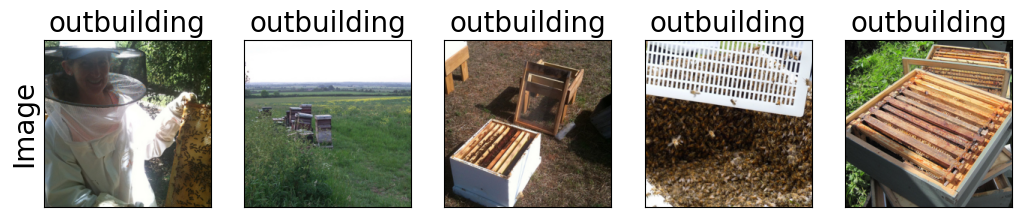

1000


In [7]:
from robustness.tools.vis_tools import show_image_row

for domain, loader in zip(["Image"], [breeds_loader]):
    im, lab = next(iter(loader))
    show_image_row([im], 
                 tlist=[[label_map[int(k)].split(",")[0] for k in lab]],
                 ylist=[domain],
                 fontsize=20)
print(len(breeds_loader.dataset))

# Embeddings

In [8]:
# Extract embeddings
embed_dict = embed_breeds(f'./embeds/ff_rn{dim}_spherical_{dataset_name}.pt', ffresnet, breeds_loader, dim, val_subclass_labels, device)
# embed_dict = embed_breeds(f'./embeds/mrl_rn{dim}_spherical_{dataset_name}.pt', mrl_resnet, breeds_loader, dim, val_subclass_labels, device, True)

embedding breeds...


  0%|                                                                                           | 0/200 [00:00<?, ?it/s]/home/ethans/miniconda3/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [00:06<00:00, 30.35it/s]


In [9]:
# OT distance prep
cost_loc = f'./files/{dataset_name}_image_costs.pt' # location for this dataset's image costs
embed_loc = f'./files/resnet_{dataset_name}.pt' # location to store embeds
image_costs = load_image_costs(cost_loc, embed_loc, breeds_loader, device)

embedding breeds...


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [00:05<00:00, 37.17it/s]


1000


# Analysis

In [10]:
# Pick embedding
embed_dict['embed'] = torch.nn.functional.normalize(embed_dict['embed'])

# Convert elements to integers if not already
embed_dict['labels'] = ltensor_to_lint(embed_dict['labels'])
embed_dict['subclass_labels'] = ltensor_to_lint(embed_dict['subclass_labels'])

In [11]:
n_subclasses = dataset_info[dataset_name]['n_subclasses']
n_superclasses = dataset_info[dataset_name]['n_superclasses'] 
superclass_accuracy = sup_acc(subclass_split, embed_dict)
subclass_accuracy = sub_acc(embed_dict)
print(f'Superclass: {superclass_accuracy}')
print(f'Subclass: {subclass_accuracy}')

Superclass: 0.751
Subclass: 0.733


In [12]:
cdm = pdist(embed_dict['embed'])
subclass_clustering, superclass_clustering = cluster(cdm, 
                                                     embed_dict['embed'],
                                                     n_subclasses,
                                                     n_superclasses)
subclass_ami, subclass_purity = metrics(embed_dict['subclass_labels'], subclass_clustering)
superclass_ami, superclass_purity = metrics(embed_dict['labels'], superclass_clustering)

# Cluster Analysis

In [13]:
print('ami:', subclass_ami)
print('purity:', subclass_purity)

ami: 0.7310125383799962
purity: 0.756


In [14]:
print('ami:', superclass_ami)
print('purity:', superclass_purity)

ami: 0.6052813483300771
purity: 0.622


# Image Merge Analysis

In [15]:
# for each merge -> separate dict for those that have same classes as original 
# separate dict for those w/diff classes than original
m = dict(sorted(find_merges(embed_dict['subclass_labels'], superclass_clustering).items()))
matches, non_matches = separate_on_matches(m, subclass_split[0])
print(non_matches.keys())
print(matches.keys())

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
dict_keys([])


In [16]:
superclass_modes = np.array(imagenet_labels)[cluster_mode(superclass_clustering, embed_dict['subclass_labels']).ravel()]
subclass_modes = np.array(imagenet_labels)[cluster_mode(subclass_clustering, embed_dict['subclass_labels']).ravel()]
def visualize_merge(merges, spherical, imagenet_labels, label_map, ds, centroids, general = False):
    """
    For each merge, displays random image from each subclass. 
    Input:
    - merges: {c2_i1: {c1_i1: [i1, i2,...], c1_i2: [i1, i2, ...], ...}, ...}
    - spherical: {'embed': array-like (n_samples, dim), 
                 'labels': [n_samples, ], 
                 'preds': [n_samples, ], 
                 'subclass_labels': [n_samples, ]}
    - imagenet_labels: (n_samples, )
    - label_map: {c2_i: name, c2_i: name, ...}
    - ds: 
    - centroids: (n_superclasses, ) of centroid classifications
    - general: label subclasses with general superclass
    Requires:
    centroids indices match indices in merges
    """
    for k, v in merges.items():
        domain = k
        ims = None
        lab = None
        sublab = None
        count = []
        for k1, v1 in v.items():
            im_idx = random.choice(v1)
            im = ds[im_idx]
            tmp_im = im[0].unsqueeze(dim=0)
            tmp_l = torch.as_tensor(im[1]).unsqueeze(dim=0)
            tmp_subl = torch.as_tensor(spherical['subclass_labels'][im_idx]).unsqueeze(dim=0)
            if ims == None and lab == None:
                ims = tmp_im
                lab = tmp_l
                sublab = tmp_subl
            else:
                ims = torch.cat([ims, tmp_im], dim=0) # ims to display in row
                lab = torch.cat([lab, tmp_l], dim=0) # superclass label of each im
                sublab = torch.cat([sublab, tmp_subl], dim=0) # subclass label of each im
            count.append(len(v1)) # count of each class in the merge
            
        ims = torch.as_tensor(ims)
        lab = torch.as_tensor(lab)
        # tlist=[label_map[int(k)].split(",")[0] + f"({c})" for k, c in zip(lab, count)], # superclass
        tlist=[imagenet_labels[k.item()].split(",")[0] + f"({c})" for k, c in zip(torch.ravel(sublab), count)], # subclass name + count
        show_image_row([ims], 
                     size=(2, 2),
                     # tlist=[[label_map[int(k)].split(",")[0] for k in lab]], # superclass
                     tlist=tlist, # subclass
                     ylist=[centroids[k].split(",")[0]],
                     fontsize=14)

In [17]:
visualize_merge(matches, embed_dict, imagenet_labels, label_map, breeds_loader.dataset, superclass_modes)

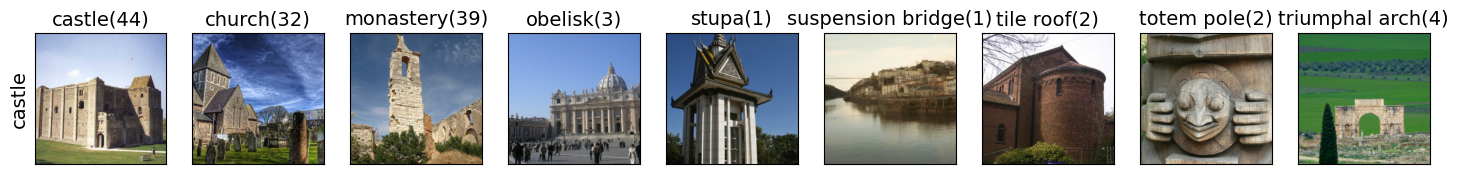

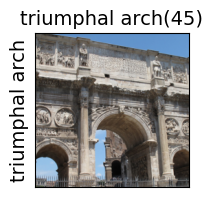

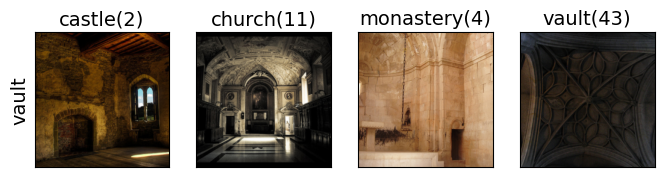

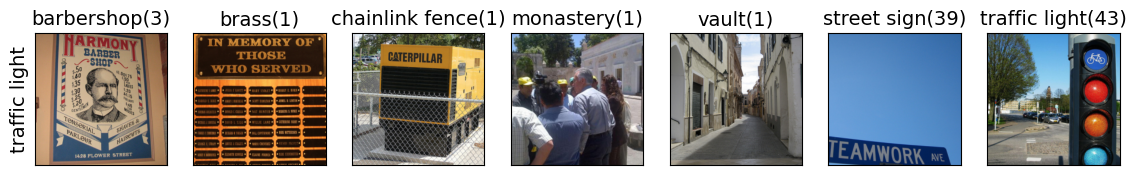

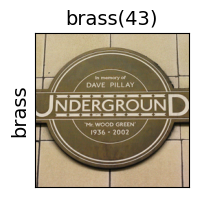

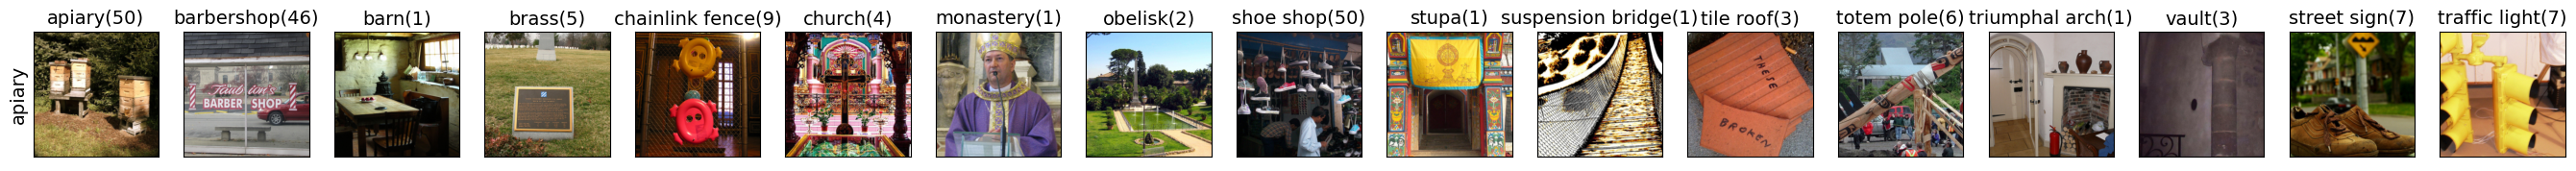

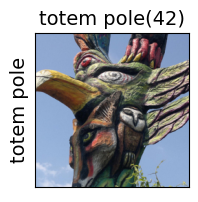

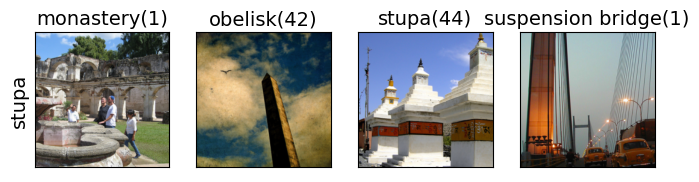

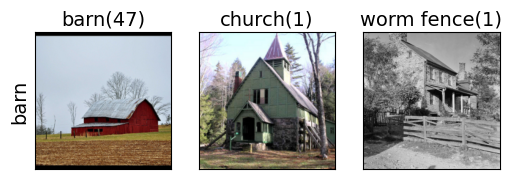

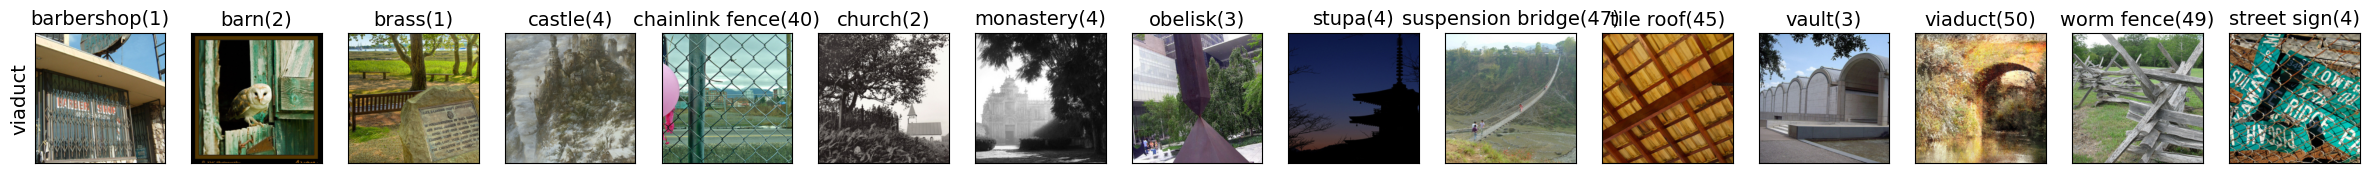

In [18]:
visualize_merge(non_matches, embed_dict, imagenet_labels, label_map, breeds_loader.dataset, superclass_modes)

# Subclass Image Merges

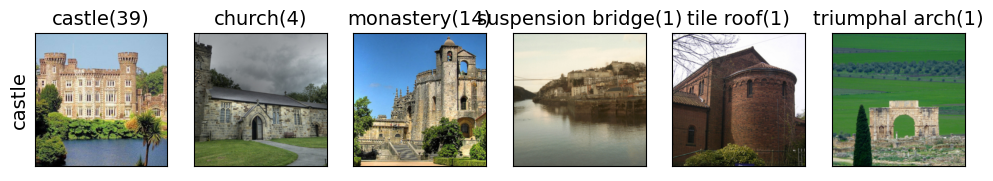

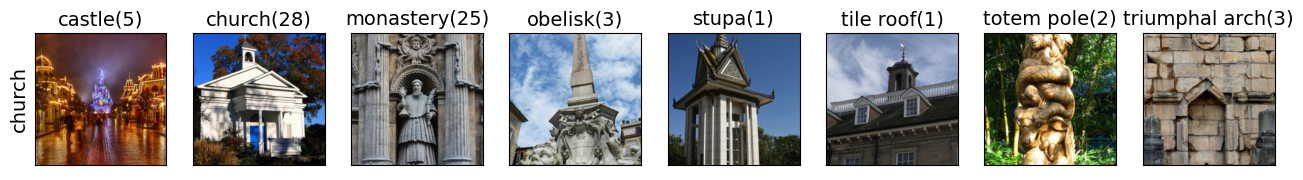

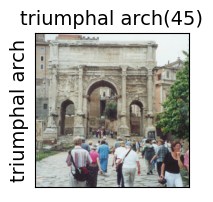

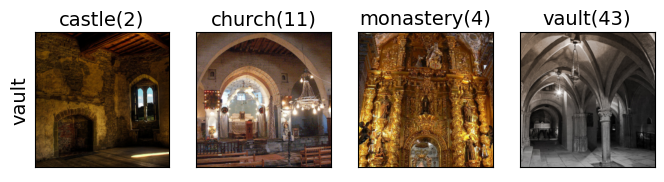

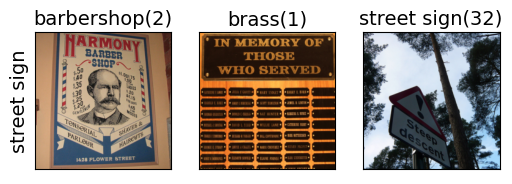

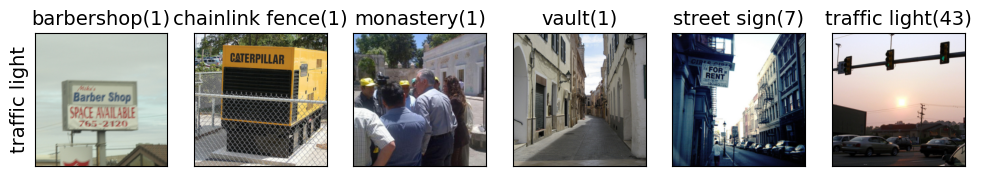

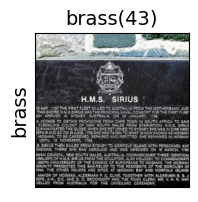

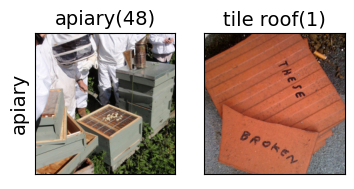

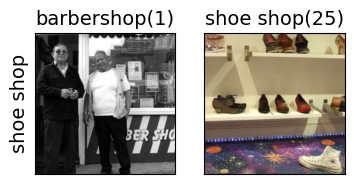

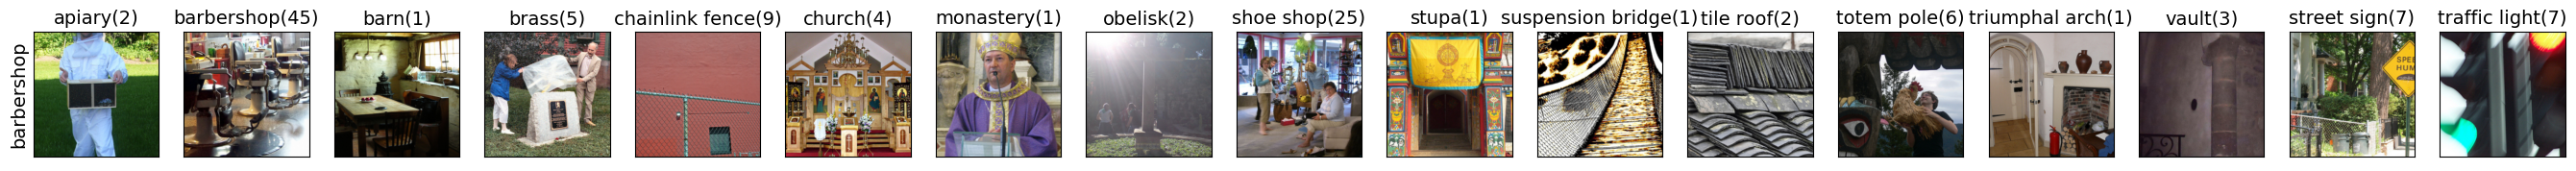

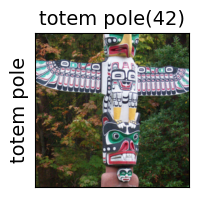

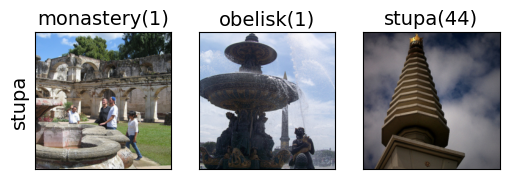

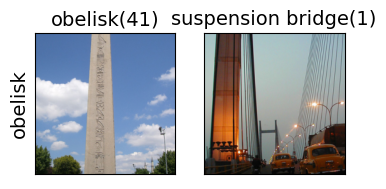

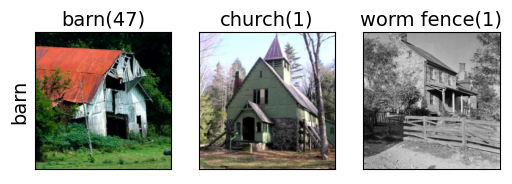

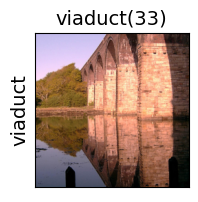

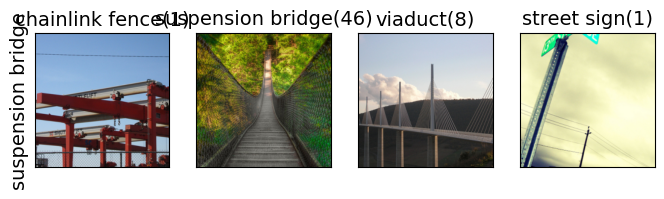

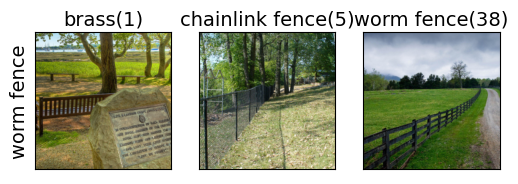

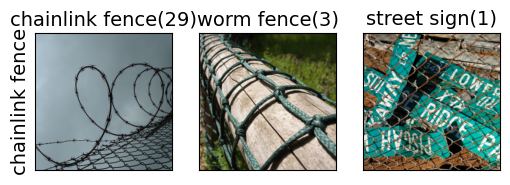

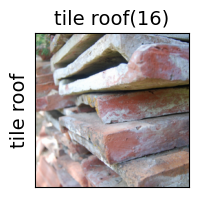

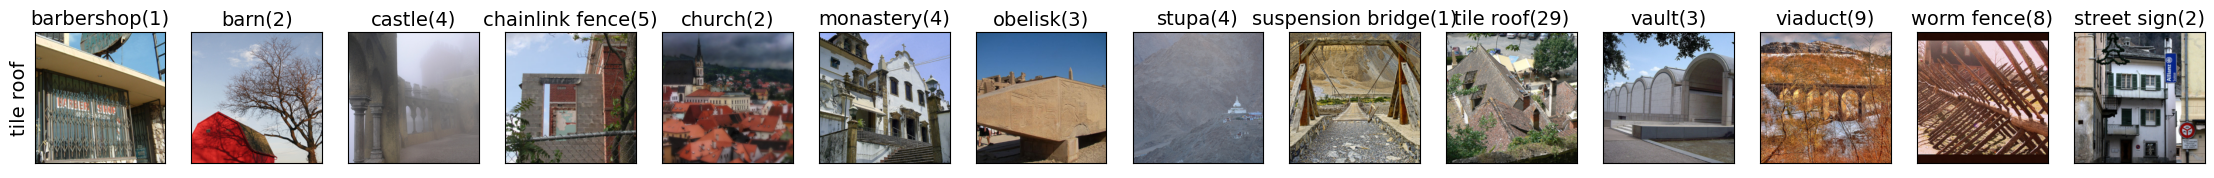

In [19]:
# temporary image analysis
m = dict(sorted(find_merges(embed_dict['subclass_labels'], subclass_clustering).items()))
visualize_merge(m, embed_dict, imagenet_labels, label_map, breeds_loader.dataset, subclass_modes)

# Distances

In [20]:
superclass_distance, _ = hhot(embed_dict['labels'], superclass_clustering, image_costs)
subclass_distance, subclass_dist = hhot(embed_dict['subclass_labels'], subclass_clustering, image_costs)
true_superclass_merge = dict(sorted(find_merges(embed_dict['subclass_labels'], embed_dict['labels']).items()))
pred_superclass_merge = dict(sorted(find_merges(subclass_clustering, superclass_clustering).items()))
h2_distance = hhot_h2(subclass_dist, true_superclass_merge, pred_superclass_merge)
h2_distance

0.8961148377221502